In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.prepocess import sample_to_rangeview
from src.settings import NUSCENES, DATASET_PATH

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
Done loading in 0.485 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


---

In [2]:
samples = NUSCENES.sample[: 10]

RV_WIDTH = 256
RV_HEIGHT = 32  # there were 32 lasers in NUSCENES' LiDAR

In [3]:
%%time
res = [sample_to_rangeview(s, width=RV_WIDTH, height=RV_HEIGHT) for s in samples]

CPU times: user 4.17 s, sys: 66.8 ms, total: 4.24 s
Wall time: 4.25 s


In [4]:
# We transpose RVs so that they are in shape, expected by torch a.k.a. [NUMBER, CHANNELS, WIDTH, HEIGHT]
range_views = np.array([r[0].T for r in res])
coordinates = np.array([r[1].T for r in res])
labels = np.array([r[2].T for r in res])

range_views.shape, coordinates.shape, labels.shape

((10, 5, 256, 32), (10, 2, 256, 32), (10, 256, 32))

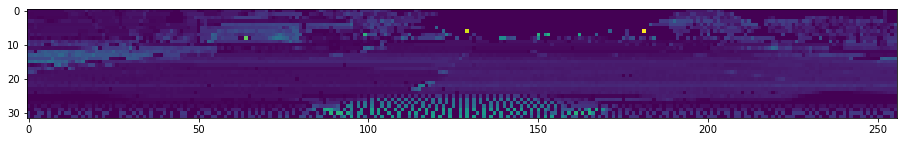

In [19]:
plt.subplots(figsize=(RV_WIDTH / 16, RV_HEIGHT / 16))
plt.imshow(range_views[0][1, :, :,].T)
plt.show()

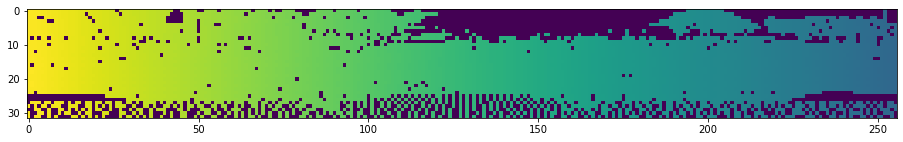

In [20]:
plt.subplots(figsize=(RV_WIDTH / 16, RV_HEIGHT / 16))
plt.imshow(range_views[0][2, :, :].T)
plt.show()

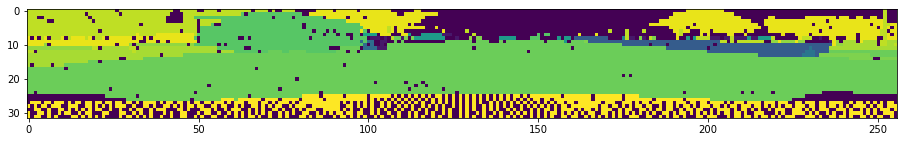

In [12]:
plt.subplots(figsize=(RV_WIDTH / 16, RV_HEIGHT / 16))
plt.imshow(labels[0].T)
plt.show()

---

- Our network is fully-convolutional and consists of three hierarchical levels as shown in Figure above. The size of convolutional kernels at each level is 64, 64, 128 respectively.


- Since the horizontal resolution of the image is significantly larger than the vertical resolution, we keep the vertical resolution constant and only perform downsampling and upsampling along the horizontal dimension.


- A final 1 × 1 convolutional layer is used to transform the resulting feature map to our encoded predictions.

In [21]:
def conv3x3(in_channels: int, 
            out_channels: int, 
            stride: int = 1, 
            padding: int = 1) -> nn.Conv2d:
    
    return nn.Conv2d(in_channels, 
                     out_channels,
                     kernel_size=3, #
                     stride=stride,
                     padding=padding)


class ResidualConv3x3Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=(1, 1)):
        super(ResidualConv3x3Block, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        out = conv3x3(self.in_channels, self.out_channels, stride=self.stride)(x)
        out = conv3x3(self.out_channels, self.out_channels, stride=self.stride)(out)
        
        # residual connection
        out += x
    
        out = self.leaky_relu(out)

        return out

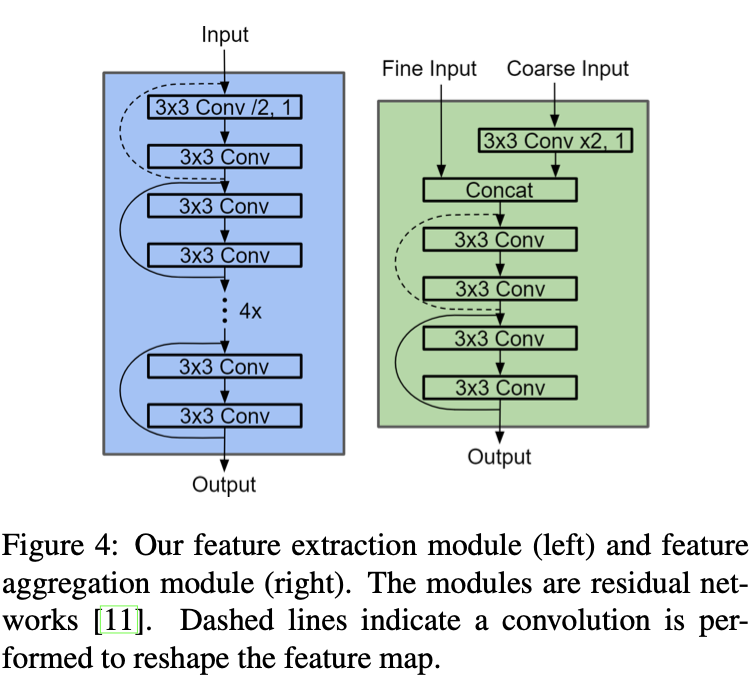

In [22]:
class FeatureExtractorBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, downsample: bool = True):
        super(FeatureExtractorBlock, self).__init__()
        
        if downsample:
            stride = (2, 1)
        else:
            stride = (1, 1)

        self.first_conv_block = nn.Sequential(
            conv3x3(in_channels=in_channels, out_channels=out_channels, stride=stride),
            conv3x3(in_channels=out_channels, out_channels=out_channels)
        )
        # we transform X so it has same dimensions as after first_block, so we can make the residual connection
        # P.S. dashed line on the image above
        self.transformed_x = conv3x3(in_channels=in_channels, out_channels=out_channels, stride=stride)
        self.elu = nn.ELU()
        self.residual_block = ResidualConv3x3Block(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

#         print('BEFORE FE|', 'x:', x.shape)


        out = self.first_conv_block(x)
        transformed_x = self.transformed_x(x)
        
        out += transformed_x
        out = self.elu(out)
        
        for _ in range(6):
            out = self.residual_block(out)
            
#         print('AFTER FE|', 'out:', out.shape)
        return out


class FeatureAggregatorBlock(nn.Module):
    
    def __init__(self, in_channels_fine, in_channels_coarse, out_channels):
        super(FeatureAggregatorBlock, self).__init__()
        
        self.in_channels_fine   = in_channels_fine
        self.in_channels_coarse = in_channels_coarse
        self.out_channels       = out_channels
        
        self.coarse_deconv = nn.ConvTranspose2d(in_channels  = self.in_channels_coarse, 
                                                out_channels = self.in_channels_coarse,
                                                kernel_size  = (2, 1),
                                                stride       = (2, 1))

        self.first_conv_block = nn.Sequential(
            conv3x3(in_channels=in_channels_fine + in_channels_coarse, out_channels=out_channels),
            conv3x3(in_channels=out_channels, out_channels=out_channels)
        )
        # we transform X so it has same dimensions as after first_block, so we can make the residual connection
        # P.S. dashed line on the image above
        self.transformed_x = conv3x3(in_channels=in_channels_fine + in_channels_coarse,
                                     out_channels=out_channels)
        self.elu = nn.ELU()

        self.residual_block2 = ResidualConv3x3Block(out_channels, out_channels)        
        
    def forward(self, fine_x: torch.Tensor, coarse_x: torch.Tensor) -> torch.Tensor:
        """
            
        """
#         print('BEFORE FA| fine_x:', fine_x.shape, 'coarse_x:', coarse_x.shape)

        coarse_x = self.coarse_deconv(coarse_x)

#         print('AFTER  DECONV| fine_x:', fine_x.shape, 'coarse_x:', coarse_x.shape)
        x = torch.cat((fine_x, coarse_x), 1)  # concatenate channels

#         print('AFTER CONCAT|', x.shape)

        out = self.first_conv_block(x)
        transformed_x = self.transformed_x(x)
        out += transformed_x
        out = self.elu(out)

        out = self.residual_block2(out)
#         print('AFTER FA|', 'out:', out.shape)

        return out

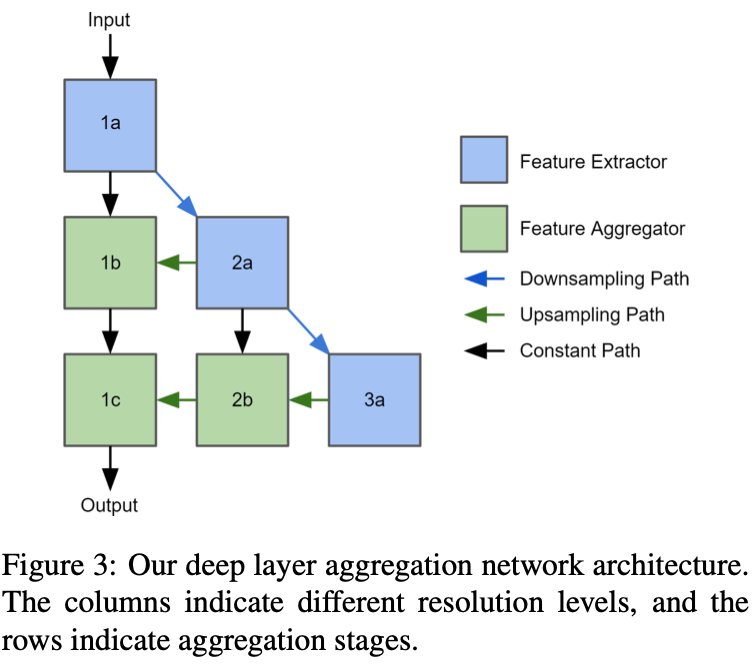

In [23]:
class DeepLayerAggregation(nn.Module):
    def __init__(self):
        super(DeepLayerAggregation, self).__init__()

        self.fe_1a = FeatureExtractorBlock(in_channels=5,
                                           out_channels=64,
                                           downsample=False)

        self.fe_2a = FeatureExtractorBlock(in_channels=64,
                                           out_channels=64)
        self.fa_1b = FeatureAggregatorBlock(in_channels_fine=64,
                                            in_channels_coarse=64,
                                            out_channels=64)
        
        self.fe_3a = FeatureExtractorBlock(in_channels=64,
                                           out_channels=128)
        self.fa_2b = FeatureAggregatorBlock(in_channels_fine=64,
                                            in_channels_coarse=128,
                                            out_channels=128)
        self.fa_1c = FeatureAggregatorBlock(in_channels_fine=64,
                                            in_channels_coarse=128,
                                            out_channels=128)


    def forward(self, x: torch.Tensor):
        
#         print('fe1a')
        out_1a = self.fe_1a(x)
        
#         print('fe2a')        
        out_2a = self.fe_2a(out_1a)
#         print('fa1b')        
        out_1b = self.fa_1b(out_1a, out_2a)
        
#         print('fe3a')                
        out_3a = self.fe_3a(out_2a)
#         print('fa2b')        
        out_2b = self.fa_2b(out_2a, out_3a)
#         print('fa1c')        
        out_1c = self.fa_1c(out_1b, out_2b)
        
        return out_1c

---

*__For each point and class of object__*, the network predicts a set of bounding box parameters $ \{ d_{x,k}, d_{y,k}, ω_{x,k}, ω_{y,k}, l_k, w_k\}^{K}_{k=1},$ a set of log standard deviations $\{s_k\}^{K}_{k=1}$, and a set of mixture weights $\{α_k\}^{K}_{k=1}$, where:


- $K$  - the number of components in the mixture model

- $(d_x,d_y)$ - a relative center

- $(ω_x,ω_y) = ( \cos ω, \sin ω )$ - a relative orientation

- $(l, w)$ - the dimensions of a BB


So the bb prediction for 1 point should be of size:  $ C * 6 * K $ 

- $C$ is the number of classes

In [24]:
def ROTATION_MATRIX(angles: torch.Tensor):
    """
        angle - tensor of size (1,1)
    """
    theta = torch.deg2rad(angles)
    cos, sin = torch.cos(theta), torch.sin(theta)
    
    s1 = torch.stack((cos, -sin))
    s2 = torch.stack((cos, sin))
    
    s3 = torch.stack((s1, s2)).squeeze(2)
    return s3

In [25]:
class LaserNet(nn.Module):
    
    def __init__(self, num_classes: int = 10, K: int = 3):
        """
            params:
                num_classes - number of target classes
                K - number of distributions of a Mixture Density Network
        """
        super(LaserNet, self).__init__()

        self.num_classes = num_classes + 1
        self.K = K  # number of distributions of a Mixture Density Network

        self.dla = DeepLayerAggregation()

        self.classes = nn.Sequential(
            nn.Conv2d(128, num_classes, kernel_size=(1, 1)),
            nn.Softmax()
        )

        # reative center (x, y), relative orientation (wx, wy) = (cos w, sin w), and dimensions l, w
        self.bb_params = nn.Conv2d(in_channels  = 128,
                                   out_channels = 6 * self.K,
                                   kernel_size  = (1, 1))

        self.log_stds = nn.Conv2d(in_channels   = 128,
                                  out_channels  = self.K,
                                  kernel_size   = (1, 1))

        self.alphas   = nn.Conv2d(in_channels   = 128,
                                  out_channels  = self.K,
                                  kernel_size   = (1, 1))        

    # TODO: move this function from class to utils
    def __params_to_abs_center(self,
                               centerX_centerY: torch.Tensor, 
                               coordinates:     torch.Tensor,
                               angles:          torch.Tensor) -> torch.Tensor:

        N, RV_HEIGHT = coordinates.shape[0], coordinates.shape[3]

        rotation_matrices = ROTATION_MATRIX(angles) #torch.Size([2, 2, 10, 256, 32])
        rotation_matrices = rotation_matrices.permute(2, 4, 3, 0, 1) #torch.Size([10, 32, 256, 2, 2])


#         print(rotation_matrices.shape, centerX_centerY.shape, coordinates.shape)
#         torch.Size([2, 2, 10, 256, 32]) torch.Size([10, 2, 256, 32]) torch.Size([10, 2, 256, 32])

        centerX_centerY = centerX_centerY.permute(0, 3, 2, 1).unsqueeze(4)  # TODO:
        coordinates = coordinates.permute(0, 3, 2, 1).unsqueeze(4)  # TODO:
        
#         print(rotation_matrices.shape, centerX_centerY.shape, coordinates.shape)
#         torch.Size([2, 2, 10, 256, 32]) torch.Size([10, 32, 256, 2, 1]) torch.Size([10, 32, 256, 2, 1])


        abs_coords = rotation_matrices @ centerX_centerY + coordinates

        return abs_coords.squeeze(4).permute(0, 3, 2, 1)  # TODO: transformation to separate function
    
    # TODO: move this function from class to utils
    def __abs_params_to_corners(self,
                                bb_abs_center_coords: torch.Tensor, 
                                bb_abs_orientation:   torch.Tensor,
                                lengths:              torch.Tensor,
                                widths:               torch.Tensor) -> torch.Tensor:
        R = ROTATION_MATRIX(bb_abs_orientation).permute(2, 3, 4, 0, 1)       
        
#         print("ROTATION_MATRIX:", R.shape,\
#               "lw:", torch.stack((lengths,widths)).unsqueeze(4).permute(1, 2, 3, 0, 4).shape)

        b1 = R @ torch.stack(( lengths,   widths)).unsqueeze(4).permute(1, 2, 3, 0, 4)  # TODO:
        b2 = R @ torch.stack(( lengths,  -widths)).unsqueeze(4).permute(1, 2, 3, 0, 4)  # TODO:
        b3 = R @ torch.stack((-lengths,  -widths)).unsqueeze(4).permute(1, 2, 3, 0, 4)  # TODO:
        b4 = R @ torch.stack((-lengths,   widths)).unsqueeze(4).permute(1, 2, 3, 0, 4)  # TODO:
        
#         print("bb_abs_center_coords:", bb_abs_center_coords.shape,\
#               "bn:", b1.squeeze(4).permute(0, 3, 1, 2).shape)
        b1 = bb_abs_center_coords + b1.squeeze(4).permute(0, 3, 1, 2)  # TODO:
        b2 = bb_abs_center_coords + b2.squeeze(4).permute(0, 3, 1, 2)  # TODO:
        b3 = bb_abs_center_coords + b3.squeeze(4).permute(0, 3, 1, 2)  # TODO:
        b4 = bb_abs_center_coords + b4.squeeze(4).permute(0, 3, 1, 2)  # TODO:

        b = torch.stack((b1, b2, b3, b4)) / 2

        return b.permute(1, 3, 4, 0, 2)
    
    # TODO: move this function from class to utils
    def __params_to_abs_box_corners(self,
                                    bb_params:   torch.Tensor, 
                                    coordinates: torch.Tensor,
                                    angles:      torch.Tensor) -> torch.Tensor:
        """
            This function turns relative predicted bounding box parameters
            into 4 coordinates of a box in an absolute coordinate system

            :bb_params tensor of size [N, K * 6, RV_WIDTH, RV_HEIGHT]
            
                    6 components are  [d_x, d_y, w_x, w_y, length, width]

            :return tensor of size    [N, K * 4, RV_WIDTH, RV_HEIGHT]
        """
        (centerX_centerY, 
         w_x,     w_y, 
         lenghts, widths) = (bb_params[:,:2], 
                             bb_params[:, 2], bb_params[:, 3], 
                             bb_params[:, 4], bb_params[:, 5])

        # getting bb centers in absolute coordinates 
        bb_abs_center_coords = self.__params_to_abs_center(centerX_centerY, coordinates, angles)

        bb_abs_orientation = angles + torch.atan2(w_x, w_y)    
        
        bb_abs_corners = self.__abs_params_to_corners(bb_abs_center_coords,
                                                      bb_abs_orientation,
                                                      lenghts,
                                                      widths)

        return bb_abs_corners

    def forward(self, x: torch.Tensor, coordinates: torch.Tensor) -> torch.Tensor:
        """
            x - tensor of size (N, 5, width, height) with main features
            coordinates - tensor of size (N, 2, width, height) containing x, y coordinates of points,
                          which are in the according cell of the X vector 
        """

        dla_out     = self.dla(x)

        class_preds = self.classes(dla_out)
        bb_params   = self.bb_params(dla_out)
        log_stds    = self.log_stds(dla_out)
        alphas      = self.alphas(dla_out)

        # bb_params is of size [N, K * 6, RV_WIDTH, RV_HEIGHT]
        # for each point on the RV, and each mixture component K we predict 6 params of a bounding box
        # these are relative to the camera frame, we need to turn them to absolute space
        # and we want to get 4 box corners instead of 6 params

        # azimuth angle is feature [2] out of 5 channels
        # I assume that azimuth is equal for points in the same RV column throughout RVs
        angles = x[:, 2, :, :]

        bb_abs_corners = self.__params_to_abs_box_corners(bb_params, coordinates, angles)


        return class_preds, bb_abs_corners, log_stds, alphas

- ___we skip Mean Shift Clustering___
- ___we also skip Adaptive NMS, and perform simple NMS___ #TODO

---

In [26]:
lasernet = LaserNet()
print(lasernet)

LaserNet(
  (dla): DeepLayerAggregation(
    (fe_1a): FeatureExtractorBlock(
      (first_conv_block): Sequential(
        (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (transformed_x): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (elu): ELU(alpha=1.0)
      (residual_block): ResidualConv3x3Block(
        (leaky_relu): LeakyReLU(negative_slope=0.01)
      )
    )
    (fe_2a): FeatureExtractorBlock(
      (first_conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (transformed_x): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
      (elu): ELU(alpha=1.0)
      (residual_block): ResidualConv3x3Block(
        (leaky_relu): LeakyReLU(negative_slope=0.01)
      )
    )
    (fa_1b): FeatureA

In [27]:
(lasernet_class_preds, lasernet_bb_params, 
 lasernet_log_stds   , lasernet_alphas   ) = lasernet(x=torch.Tensor(range_views),
                                                      coordinates=torch.Tensor(coordinates))

print("class predictions shape", lasernet_class_preds.shape)
print("bb predictions shape", lasernet_bb_params.shape)
print("log_stds predictions shape", lasernet_log_stds.shape)
print("alphas predictions shape", lasernet_alphas.shape)

class predictions shape torch.Size([10, 10, 256, 32])
bb predictions shape torch.Size([10, 256, 32, 4, 2])
log_stds predictions shape torch.Size([10, 3, 256, 32])
alphas predictions shape torch.Size([10, 3, 256, 32])


/Users/alvandyan/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


---

## Loading data 

- Model takes the _Range View_ image as an input.

- _Range View_ consists of a number of points, collected into height and width bins, each point in that cell having their relative x, y coordinates 

__NOTE! not the coordinates of a point in the RV image, but coordinates of each cell's point in the original lidar point space__ 

- sample_annotation  Bounding Box is given in _absolute_ coordinates **center_x**, **center_y**, **center_z** of a BB center, it's **length**, **width** and orientation as a quaternion: **w**, **x**, **y**, **z**.

- after model's prediction we make a differentiable change of space coordinates, and final predictions come in the absolute space.


- We are solving two tasks - Classification and Regression.
- ___Classification___ task includes semantic segmentation. We predict class labels for each point (cell) in the Range View. If a cell in RV gets a class C, we extrapolate that all points (which fell into that cell during the transformation to RV) get the same label.
- ___Regression___ task includes BB regression and mixture parameter tuning

so the (x, y) training pair is: 

- __$X$__: range_view image | __5 x W x H__


- __$Y_{image}$:__ $Y_{image}$[ h ][ w ] containing cell's class | __C x W x H__, where C - number of classes


- __$Y_{bb}$:__ $\{\{b_{m,1}, b_{m,2}, b_{m,3}, b_{m,4}\}, ..., \}_m^M$ | __M x 4 x 2 x W x H__ | where M is the number of bounding boxes in the image, $b_{m, j} \in R ^2$ is the absolute coordinate of a bounding box's $j$-th corner
    

### X

In [99]:
range_views.shape, coordinates.shape

((10, 5, 256, 32), (10, 2, 256, 32))

### $Y_{image}$

In the dataset, class labels are on the LiDAR points, not the images

In [28]:
labels.shape

(10, 256, 32)

### $Y_{bb}$

---

## Training the model
*TODO: maybe also do experiments without mixture network (?)*

1. For each point in the image, we use the focal loss $L_{prob}$ to learn the class probabilities $\{p_c\}_{c=1}^C$. The classification loss for the entire image is defined as follows 
$$
L_{cls} = {1 \over P} \sum_i{L_{prob, i}}
$$ 
where P is the number of points in the image


2. For each point on an object, we learn the parameters of the object’s mixture model by first identifying which component best matches the ground truth
$$
k^* = \arg \min_k || \hat b_k − b^{gt} ||
$$
where $\hat b_k$ is the k-th mean component of the mixture model
and $b^{gt}$ is the corresponding ground truth bounding box. Afterwards, we update the parameters of the $k^{*}$ component
$$
L_{box} = \sum_n {1 \over \hat \sigma_{k^*}} | \hat b_{n, k} − b^{gt}_n | + \log{\hat \sigma_{k^*}}
$$

3. Next, we update the mixture weights $\{α_k\}^K_{k=1}$ again using the multi-class cross entropy loss $L_{mix}$, where the positive label corresponds to the $k^*$ component

4. The regression loss for the entire image is defined as follows:
$$
L_{reg} = {{1 \over N} \sum_i{L_{box, i} + \lambda L_{mix, i} \over n_i}}
$$
where $L_{box, i}$ and $L_{mix, i}$ are the losses for the $i$-th point in the image which is on an object, $n_i$ is the total number of points that lie on the same object as $i$, $N$ is the total instances of objects in the image, and $\lambda$ is the relative weighting of the two losses.